# Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pet_cli.tcms_as_convolutions as pet_tcm
import pet_cli.reference_tissue_models as pet_rtms
from importlib import reload

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.6)
plt.rcParams['font.family'] ='StixGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

# Simplified Reference Tissue Model (SRTM)

The analytical solution for the SRTM describes the tissue TAC, $C(t)$, as a function of a reference TAC, $C_\mathrm{R}(t)$, is:
$$
C(t) = R_{1} C_\mathrm{R}(t) + \left( k_{2} - \frac{R_{1}k_{2}}{1+\mathrm{BP_\mathrm{ND}}} \right) C_\mathrm{R}(t)\otimes \exp\left[-\frac{k_{2}}{1+\mathrm{BP_\mathrm{ND}}} t\right].
$$
By defining $\alpha\equiv\frac{k_{2}}{1+\mathrm{BP_\mathrm{ND}}}$, we can rewrite the equation as:
$$
C(t) = R_{1} C_\mathrm{R}(t) + \left( k_{2} - R_{1}\alpha\right) C_\mathrm{R}(t)\otimes \exp\left[-\alpha \cdot t\right].
$$

## Loading An Input Function

In [2]:
input_tac_times, input_tac_vals = np.asarray(np.loadtxt("../../data/tcm_tacs/fdg_plasma_clamp_evenly_resampled.txt").T, float)
# input_tac_times *= 60.0 #To change time to seconds

## Generating An Example Reference Region
We use a 1TCM with $K_1=0.5$ and $k_2=2.0$.

In [3]:
ref_tac_times, ref_tac_vals  = pet_tcm.generate_tac_1tcm_c1_from_tac(tac_times=input_tac_times,
                                                                     tac_vals=input_tac_vals,
                                                                     k1=0.5, 
                                                                     k2=2.0)

### Example SRTM TAC
We use $R_1=0.5$, $k_2=1.0$ and $BP=3.0$.

In [4]:
srtm_test_params = np.asarray((0.5, 1.0, 3.0))
srtm_tac_vals = pet_rtms.calc_srtm_tac(tac_times=ref_tac_times, 
                                      ref_tac_vals=ref_tac_vals, 
                                      r1=srtm_test_params[0], 
                                      k2=srtm_test_params[1], 
                                      bp=srtm_test_params[2])

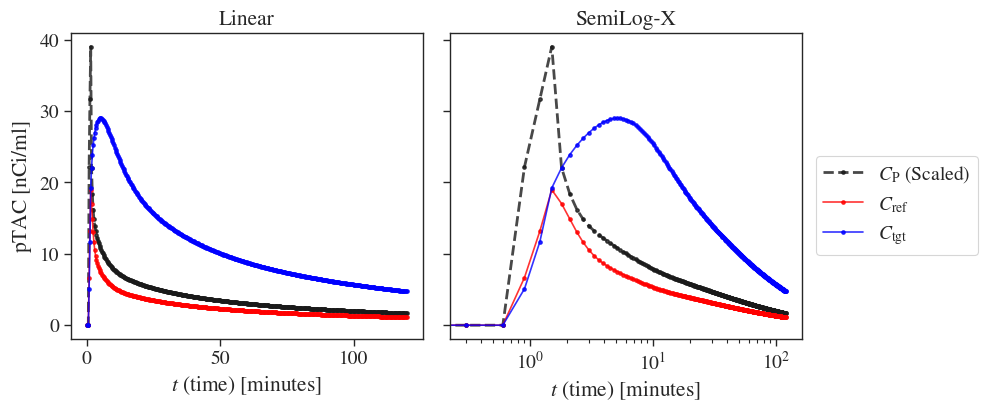

In [5]:
myFig, myAx = plt.subplots(1,2, constrained_layout=True, figsize=[8,4], sharey=True)
for anAx in myAx.flatten():
    anAx.plot(input_tac_times, input_tac_vals/2., '.--', alpha=0.8, color='k', label=r'$C_\mathrm{P}$ (Scaled)', lw=2)
    anAx.plot(ref_tac_times, ref_tac_vals, '.-', alpha=0.8, color='red', label=r'$C_\mathrm{ref}$')
    anAx.plot(ref_tac_times, srtm_tac_vals, '.-', alpha=0.8, color='blue', label=r'$C_\mathrm{tgt}$')
    anAx.set(xlabel=r'$t$ (time) [minutes]')
myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear')
myAx[1].set(xscale='log', title='SemiLog-X')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left')
plt.show()

## Simple Visual Inspection Of Fits

### Convenience Functions For Formatting And Adding Noise To TACs

In [38]:
reload(pet_rtms)
def calc_diff(real_answer, new_answer):
    diff = new_answer - real_answer
    per_d = diff / real_answer * 100.
    
    return new_answer, diff, per_d

def print_arrs(pre_str:str, *args):
    print(f"{pre_str+':':<8}", end=' ')
    for an_arr in args:
        str_arr = [f"{a_num:<5.2f}" for a_num in an_arr]
        print(f"({', '.join(str_arr)})", end='; ')
    print()

In [39]:
def add_gaussian_noise_to_tac(tac_vals: np.ndarray, scale: float =0.2) -> np.ndarray:
    noise = np.random.normal(loc=0.0, scale=scale, size=tac_vals.shape)
    tac_out = tac_vals + noise
    tac_out[0] = 0.0
    return tac_out

def add_gaussian_noise_to_tac_based_on_max(tac_vals: np.ndarray, scale: float = 0.05) -> np.ndarray:
    noise = np.random.normal(loc=0.0, scale=np.max(tac_vals)*scale, size=tac_vals.shape)
    tac_out = tac_vals + noise
    tac_out[0] = 0.0
    return tac_out

### Generating Random Samples For Free Parameters

In [8]:
num_samples = 5
r1_params = np.random.random(num_samples)*10.0 + 0.001
k2_params = np.random.random(num_samples)*10.0 + 0.001
bp_params = np.random.random(num_samples)*10.0 + 0.001

srtm_test_params = np.vstack([r1_params, k2_params, bp_params]).T

srtm_test_params

array([[5.26359754, 3.21929692, 8.25169074],
       [5.56518124, 4.27314425, 3.44094386],
       [5.6121332 , 0.64476457, 9.5348021 ],
       [2.1485416 , 8.67066538, 2.63662525],
       [0.55549991, 0.2464476 , 0.16733144]])

### Plotting Data And Fits Together

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (5.26 , 3.22 , 8.25 ); 
pOpt:    (5.33 , 2.97 , 8.27 ); (0.07 , -0.25, 0.02 ); (1.27 , -7.83, 0.25 ); 


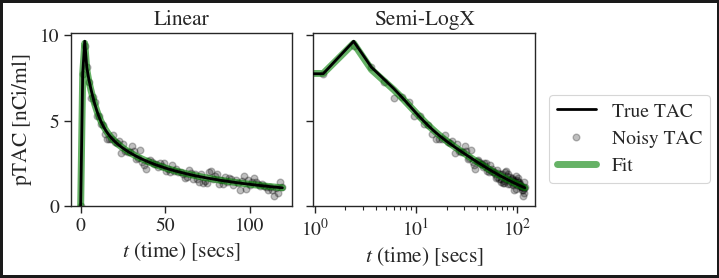

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (5.57 , 4.27 , 3.44 ); 
pOpt:    (5.50 , 5.12 , 3.49 ); (-0.07, 0.85 , 0.05 ); (-1.23, 19.88, 1.34 ); 


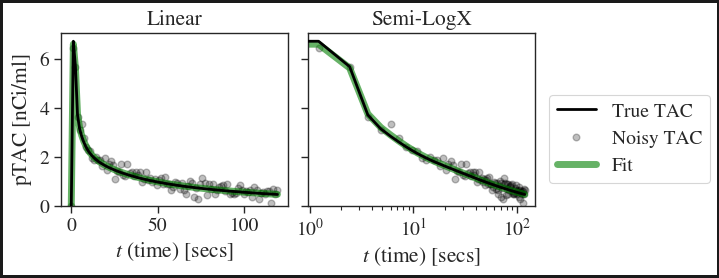

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (5.61 , 0.64 , 9.53 ); 
pOpt:    (5.57 , 0.66 , 9.50 ); (-0.04, 0.01 , -0.03); (-0.67, 2.19 , -0.34); 


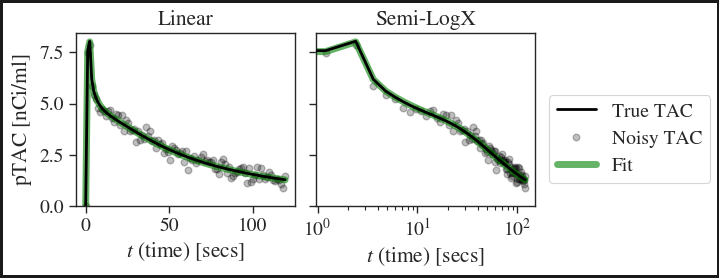

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (2.15 , 8.67 , 2.64 ); 
pOpt:    (2.08 , 8.41 , 2.63 ); (-0.07, -0.27, -0.00); (-3.42, -3.06, -0.17); 


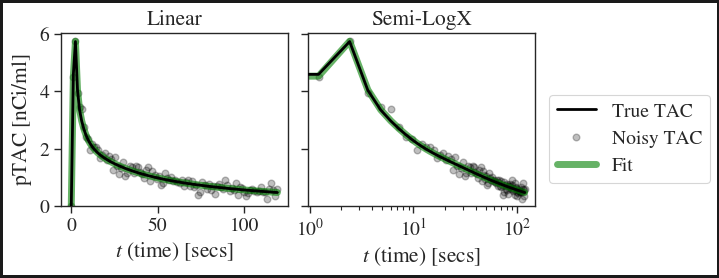

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (0.56 , 0.25 , 0.17 ); 
pOpt:    (0.56 , 0.24 , 0.16 ); (0.00 , -0.00, -0.00); (0.48 , -1.13, -2.78); 


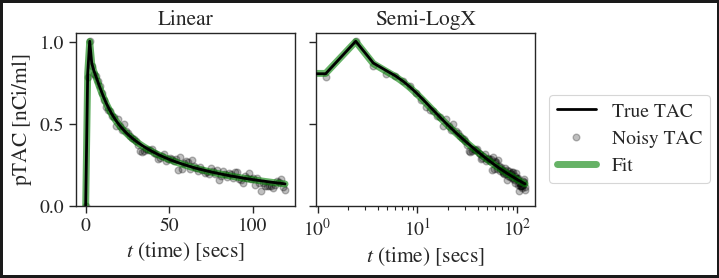

In [40]:
stride = 4
model_func = pet_rtms.calc_srtm_tac
for tID, t_params in enumerate(srtm_test_params[:]):
    rtm_tac_vals = model_func(ref_tac_times, *t_params, ref_tac_vals)
    if np.min(rtm_tac_vals) < 0:
        continue
    print('-' * 80)
    print(f"{'Value':<30};{'Diff':<22};{'%Diff':<32}")

    noisy_tgt_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals, scale=0.02)
    
    pOpt, pCor = pet_rtms.fit_srtm_to_tac_with_bounds(tgt_tac_vals=noisy_tgt_vals, 
                                                      ref_tac_times=ref_tac_times,
                                                      ref_tac_vals=ref_tac_vals,
                                                      r1_bounds=(1.0, 0.0001, 10.0),
                                                      k2_bounds=(1.0, 0.0001, 10.0), 
                                                      bp_bounds=(1.0, 0.0001, 10.0))
    print_arrs("Actual", t_params)
    print_arrs("pOpt", *calc_diff(t_params, pOpt))
    
    myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8/1.5, 4/1.5], sharey=True, linewidth=3.0, edgecolor='k')
    for anAx in myAx.flatten():
        anAx.plot(ref_tac_times[::stride], rtm_tac_vals[::stride], '-', alpha=1.0, color='black',
                  label=r'True TAC', lw=2.0, zorder=4)
        anAx.plot(ref_tac_times[::stride], noisy_tgt_vals[::stride], 'o', alpha=0.25, color='black',
                  label=r'Noisy TAC')
        yAr = model_func(ref_tac_times, *pOpt, ref_tac_vals)
        anAx.plot(ref_tac_times[::stride], yAr[::stride], '-', alpha=0.6, color='green', lw=5, label='Fit')
    
    leg_hands, leg_labs = list(myAx[0].get_legend_handles_labels())
    
    myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear', ylim=(-0.25, None), xlabel='$t$ (time) [secs]')
    myAx[1].set(xscale='log', ylim=(-0.0001, None), title='Semi-LogX', xlabel='$t$ (time) [secs]')
    
    myFig.legend(leg_hands, leg_labs, bbox_to_anchor=(1.0, 0.5), loc='center left')
    plt.show()


## Generating A Simple Scatter Plot Of Fits vs. Real Values From Many Random Values

### Unbounded Fits

In [22]:
from scipy.stats import linregress
from scipy.stats import pearsonr
text_box=dict(facecolor='lightblue', edgecolor='black', lw=2, alpha=0.2)

#### Generating Random Samples

In [44]:
num_samples = 5000
r1_params = np.random.random(num_samples)*5.0  + 0.01
k2_params = np.random.random(num_samples)*5.0 + 0.01
bp_params = np.random.random(num_samples)*5.0 + 0.01
srtm_test_params_large = np.vstack([r1_params, k2_params, bp_params]).T

model_func = pet_rtms.calc_srtm_tac
srtm_fit_params_unbounded = np.zeros_like(srtm_test_params_large)
for tID, t_params in enumerate(srtm_test_params_large[:]):
    rtm_tac_vals = model_func(ref_tac_times, *t_params, ref_tac_vals)
    if np.min(rtm_tac_vals) < 0.0:
        srtm_fit_params_unbounded[tID] = np.nan * np.ones(len(t_params), float)
        continue
    noisy_tgt_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals, scale=0.01)
    try:
        pOpt, pCor = pet_rtms.fit_srtm_to_tac(tgt_tac_vals=noisy_tgt_vals, 
                                              ref_tac_times=ref_tac_times,
                                              ref_tac_vals=ref_tac_vals)
    except RuntimeError:
        pOpt = np.nan * np.ones(len(t_params), float)
        pCor = np.nan * np.ones((len(t_params), len(t_params)), float)
        
    srtm_fit_params_unbounded[tID] = pOpt[:]

#### Scatter Plot

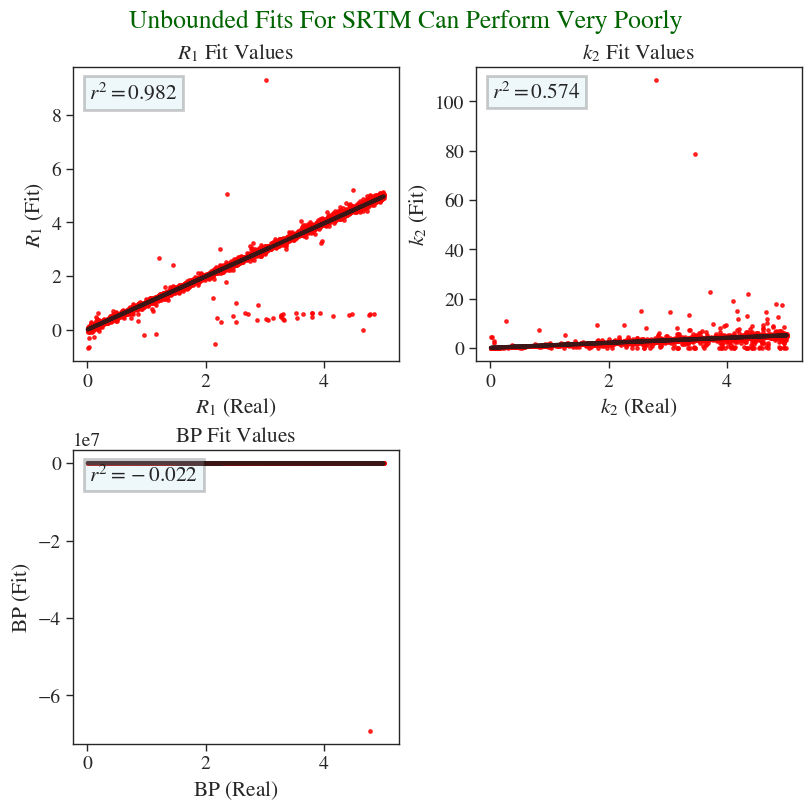

In [45]:
srtm_param_names = [r'$R_1$', r'$k_2$', r'$\mathrm{BP}$']
myFig, myAx = plt.subplots(2,2, figsize=[8,8], constrained_layout=True)
fAx = myAx.flatten()
for pID, (xAr, yAr, param) in enumerate(zip(srtm_test_params_large.T, 
                                            srtm_fit_params_unbounded.T,
                                            srtm_param_names)):
    lin_reg = linregress(xAr[~np.isnan(yAr)], yAr[~np.isnan(yAr)])
    fAx[pID].plot(xAr, yAr, '.', alpha=0.8, color='red')
    fAx[pID].plot(xAr, xAr*lin_reg.slope + lin_reg.intercept, lw=3, color='k', alpha=0.85)
    
    fAx[pID].text(0.05, 0.95, fr"$r^2={lin_reg.rvalue:<5.3f}$", 
                  transform=fAx[pID].transAxes, ha='left', va='top', bbox=text_box)
    fAx[pID].set_title(f"{param} Fit Values")
    fAx[pID].set(xlabel=fr'{param} (Real)', ylabel=fr'{param} (Fit)')
fAx[-1].axis('off')
myFig.suptitle("Unbounded Fits For SRTM Can Perform Very Poorly", color='darkgreen')
plt.show()

### Bounded Fits

#### Generating Random Samples

In [46]:
num_samples = 5000
r1_params = np.random.random(num_samples)*5.0  + 0.01
k2_params = np.random.random(num_samples)*5.0 + 0.01
bp_params = np.random.random(num_samples)*5.0 + 0.01
srtm_test_params_large = np.vstack([r1_params, k2_params, bp_params]).T

model_func = pet_rtms.calc_srtm_tac
srtm_fit_params_bounded = np.zeros_like(srtm_test_params_large)
for tID, t_params in enumerate(srtm_test_params_large[:]):
    rtm_tac_vals = model_func(ref_tac_times, *t_params, ref_tac_vals)
    if np.min(rtm_tac_vals) < 0.0:
        srtm_fit_params_bounded[tID] = np.nan * np.ones(len(t_params), float)
        continue
    noisy_tgt_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals, scale=0.01)
    try:
        pOpt, pCor = pet_rtms.fit_srtm_to_tac_with_bounds(tgt_tac_vals=noisy_tgt_vals, 
                                                          ref_tac_times=ref_tac_times,
                                                          ref_tac_vals=ref_tac_vals,
                                                          r1_bounds=(1.0, 0.0001, 10.0),
                                                          k2_bounds=(1.0, 0.0001, 10.0), 
                                                          bp_bounds=(1.0, 0.0001, 10.0))

    except RuntimeError:
        print(t_params)
        pOpt = np.nan * np.ones(len(t_params), float)
        pCor = np.nan * np.ones((len(t_params), len(t_params)), float)
    srtm_fit_params_bounded[tID] = pOpt[:]
    

#### Scatter Plot

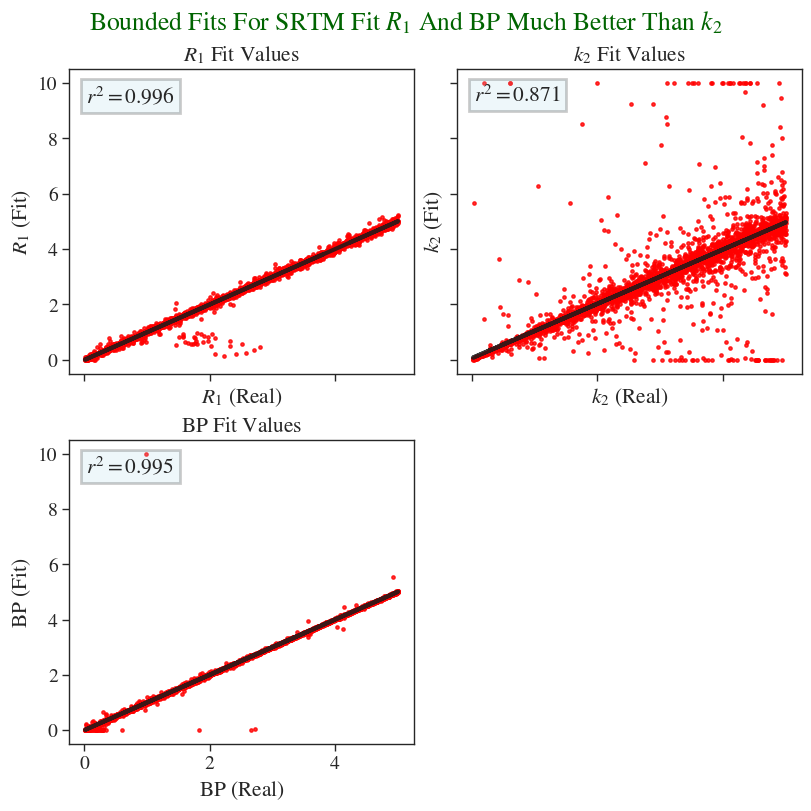

In [47]:
srtm_param_names = [r'$R_1$', r'$k_2$', r'$\mathrm{BP}$']
myFig, myAx = plt.subplots(2,2, figsize=[8,8], constrained_layout=True, sharex=True, sharey=True)
fAx = myAx.flatten()
for pID, (xAr, yAr, param) in enumerate(zip(srtm_test_params_large.T, 
                                            srtm_fit_params_bounded.T,
                                            srtm_param_names)):
    lin_reg = linregress(xAr[~np.isnan(yAr)], yAr[~np.isnan(yAr)])
    fAx[pID].plot(xAr, yAr, '.', alpha=0.8, color='red')
    fAx[pID].plot(xAr, xAr*lin_reg.slope + lin_reg.intercept, lw=3, color='k', alpha=0.85)
    
    fAx[pID].text(0.05, 0.95, fr"$r^2={lin_reg.rvalue:<5.3f}$", 
                  transform=fAx[pID].transAxes, ha='left', va='top', bbox=text_box)
    fAx[pID].set_title(f"{param} Fit Values")
    fAx[pID].set(xlabel=fr'{param} (Real)', ylabel=fr'{param} (Fit)')
fAx[-1].axis('off')
myFig.suptitle("Bounded Fits For SRTM Fit $R_1$ And $\mathrm{BP}$ Much Better Than $k_2$", color='darkgreen')
plt.show()

# Full Reference Tissue Model (FRTM)

Given, $R_{1}\equiv \frac{k_{1}^{\prime}}{k_{1}^{\prime}}$, the analytical solution for the FRTM, as a function of some reference region TAC, $C_\mathrm{R}(t)$, can be written as:
$$
C(t) = R_{1}C_\mathrm{R}(t) + \left[ A_{1}e^{-\alpha_{1}t} + A_{2}e^{-\alpha_{2}t} \right] \otimes C_\mathrm{R}(t),
$$
where the $\alpha_1$, $\alpha_2$, $A_1$, and $A_2$ depend on the underlying kinetic constants $k_2$, $k_3$, $k_4$, along with the predefined $R_1$, as:
$$
\begin{align}
\alpha_{1} &= \frac{k_{2} + k_{3} + k_{4} - \sqrt{\left( k_{2} + k_{3} + k_{4} \right)^2 - 4k_{2}k_{4}}}{2}\\
\alpha_{2} &= \frac{k_{2} + k_{3} + k_{4} + \sqrt{\left( k_{2} + k_{3} + k_{4} \right)^2 - 4k_{2}k_{4}}}{2}\\
A_{1} &= \left( \frac{k_{3} + k_{4} -\alpha_{2}}{\alpha_{1} - \alpha_{2}} \right)\left( \frac{k_{2}}{R_{1}} - \alpha_{2} \right)\\
A_{2} &= \left(  \frac{\alpha_{1}-k_{3} - k_{4} }{\alpha_{1} - \alpha_{2}} \right)\left( \frac{k_{2}}{R_{1}} - \alpha_{1} \right)
\end{align}
$$
Here, we can define $\beta\equiv k_{2} + k_{3} +k_{4}$, and $\chi\equiv\sqrt{\beta^2 - 4k_{2}k_{4}}$ to make the $\alpha$'s more compact:
$$
\begin{align}
\alpha_{1} &= \frac{\beta - \chi}{2}\\
\alpha_{2} &= \frac{\beta + \chi}{2}\\
A_{1} &= \left(\frac{k_{3} + k_{4} -\alpha_{2}}{\chi} \right)\left( \frac{k_{2}}{R_{1}} - \alpha_{2} \right)\\
A_{2} &= \left(\frac{\alpha_{1}-k_{3} - k_{4} }{\chi} \right)\left( \frac{k_{2}}{R_{1}} - \alpha_{1} \right)
\end{align}
$$


## Generating An Example Reference Region
We use a 1TCM with $K_1=1.5$ and $k_2=0.05$.

In [15]:
ref_tac_times, ref_tac_vals  = pet_tcm.generate_tac_1tcm_c1_from_tac(tac_times=input_tac_times,
                                                                     tac_vals=input_tac_vals,
                                                                     k1=0.05, 
                                                                     k2=2.0)

### Example FRTM TAC
We use $R_1=0.5$, $k_2=0.01$, $k_3=0.3$ and $k_4=0.01$.

In [50]:
frtm_test_params = np.asarray((0.5, 0.01, 0.3, 0.01))
frtm_tac_vals = pet_rtms.calc_frtm_tac(tac_times=ref_tac_times, 
                                       ref_tac_vals=ref_tac_vals, 
                                       r1=frtm_test_params[0],
                                       k2=frtm_test_params[1], 
                                       k3=frtm_test_params[2],
                                       k4=frtm_test_params[3])


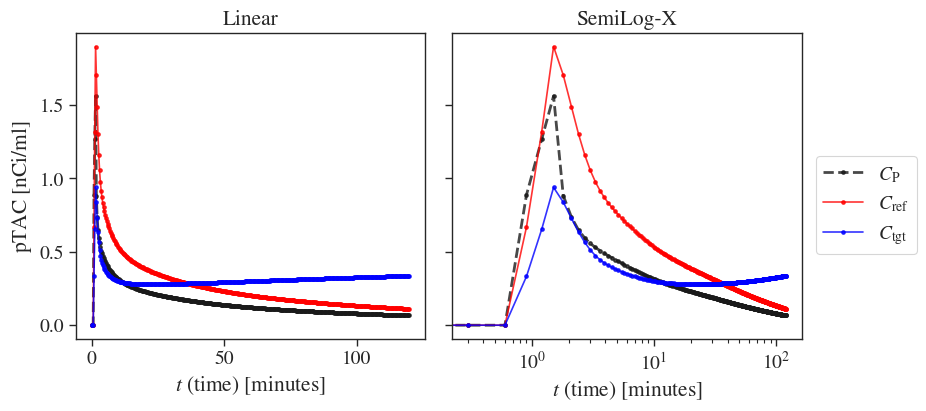

In [51]:
myFig, myAx = plt.subplots(1,2, constrained_layout=True, figsize=[8,4], sharey=True)
for anAx in myAx.flatten():
    anAx.plot(input_tac_times, input_tac_vals/50., '.--', alpha=0.8, color='k', label=r'$C_\mathrm{P}$', lw=2)
    anAx.plot(ref_tac_times, ref_tac_vals, '.-', alpha=0.8, color='red', label=r'$C_\mathrm{ref}$')
    anAx.plot(ref_tac_times, frtm_tac_vals, '.-', alpha=0.8, color='blue', label=r'$C_\mathrm{tgt}$')
    anAx.set(xlabel=r'$t$ (time) [minutes]')
myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear')
myAx[1].set(xscale='log', title='SemiLog-X')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left')
plt.show()

## Simple Visual Inspection Of Fits

### Generating Ramdom Samples For The Parameters

In [53]:
num_samples = 5
r1_params = np.random.random(num_samples)*5.0 + 0.001
k2_params = np.random.random(num_samples)*5.0 + 0.001
k3_params = np.random.random(num_samples)*5.0 + 0.001
k4_params = np.random.random(num_samples)*5.0 + 0.001

frtm_test_params = np.vstack([r1_params, k2_params, k3_params, k4_params]).T

frtm_test_params

array([[0.81804396, 1.71515492, 4.62296822, 4.24863398],
       [4.00679058, 2.72613425, 0.13618858, 4.74244809],
       [4.10564161, 4.14972269, 2.21475828, 2.08785208],
       [2.68543151, 2.61031024, 3.24698101, 0.452098  ],
       [4.04286093, 2.04250938, 1.60583257, 4.17035068]])

### Plotting Data And Fits Together

--------------------------------------------------------------------------------
Value                                ;Diff                         ;%Diff                           
Actual:  (0.82 , 1.72 , 4.62 , 4.25 ); 
pOpt:    (0.91 , 6.00 , 1.54 , 0.97 ); (0.09 , 4.28 , -3.08, -3.28); (10.72, 249.82, -66.58, -77.21); 


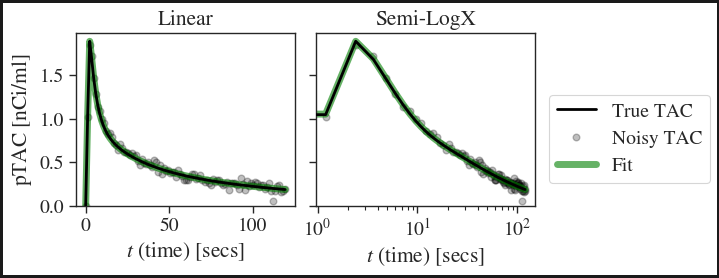

--------------------------------------------------------------------------------
Value                                ;Diff                         ;%Diff                           
Actual:  (4.01 , 2.73 , 0.14 , 4.74 ); 
pOpt:    (4.10 , 2.10 , 0.00 , 3.43 ); (0.09 , -0.62, -0.14, -1.32); (2.26 , -22.86, -99.93, -27.74); 


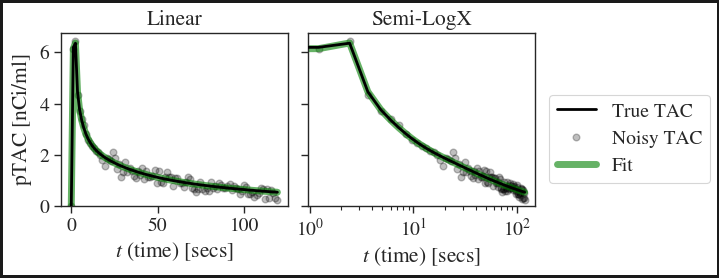

--------------------------------------------------------------------------------
Value                                ;Diff                         ;%Diff                           
Actual:  (4.11 , 4.15 , 2.21 , 2.09 ); 
pOpt:    (4.26 , 3.80 , 1.00 , 1.62 ); (0.15 , -0.35, -1.21, -0.47); (3.72 , -8.33, -54.78, -22.51); 


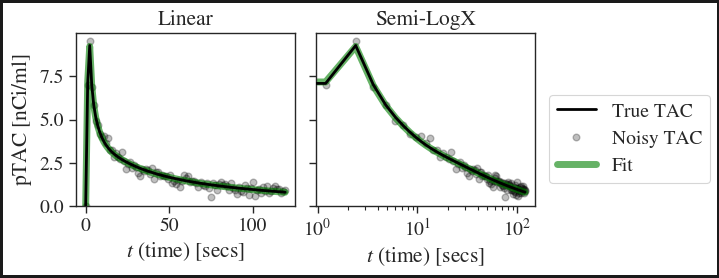

--------------------------------------------------------------------------------
Value                                ;Diff                         ;%Diff                           
Actual:  (2.69 , 2.61 , 3.25 , 0.45 ); 
pOpt:    (2.59 , 3.08 , 0.72 , 0.24 ); (-0.10, 0.47 , -2.53, -0.21); (-3.60, 18.01, -77.98, -47.23); 


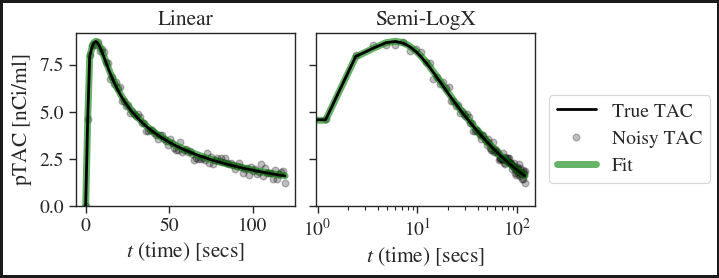

--------------------------------------------------------------------------------
Value                                ;Diff                         ;%Diff                           
Actual:  (4.04 , 2.04 , 1.61 , 4.17 ); 
pOpt:    (2.89 , 6.00 , 0.00 , 2.62 ); (-1.15, 3.96 , -1.61, -1.55); (-28.46, 193.76, -99.99, -37.26); 


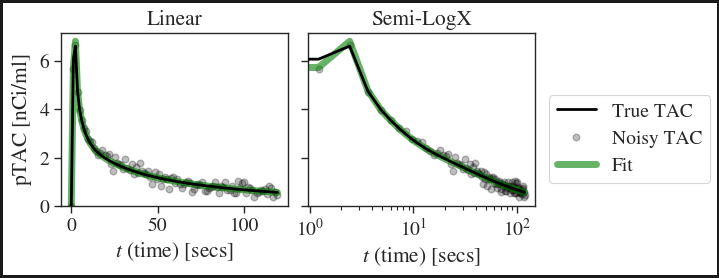

In [54]:
stride = 4 # To reduce the number of shown points for clarity
model_func = pet_rtms.calc_frtm_tac
for tID, t_params in enumerate(frtm_test_params[:]):
    rtm_tac_vals = model_func(ref_tac_times, *t_params, ref_tac_vals)
    if np.min(rtm_tac_vals) < 0:
        continue
    print('-' * 80)
    print(f"{'Value':<37};{'Diff':<29};{'%Diff':<32}")

    noisy_tgt_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals, scale=0.02)
    
    pOpt, pCor = pet_rtms.fit_frtm_to_tac_with_bounds(tgt_tac_vals=noisy_tgt_vals, 
                                                      ref_tac_times=ref_tac_times,
                                                      ref_tac_vals=ref_tac_vals,
                                                      r1_bounds=(1.0, 0.0001, 6.0),
                                                      k2_bounds=(1.0, 0.0001, 6.0), 
                                                      k3_bounds=(1.0, 0.0001, 6.0),
                                                      k4_bounds=(1.0, 0.0001, 6.0))
    print_arrs("Actual", t_params)
    print_arrs("pOpt", *calc_diff(t_params, pOpt))
    
    myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8/1.5, 4/1.5], sharey=True, linewidth=3.0, edgecolor='k')
    for anAx in myAx.flatten():
        anAx.plot(ref_tac_times[::stride], rtm_tac_vals[::stride], '-', alpha=1.0, color='black',
                  label=r'True TAC', lw=2.0, zorder=4)
        anAx.plot(ref_tac_times[::stride], noisy_tgt_vals[::stride], 'o', alpha=0.25, color='black',
                  label=r'Noisy TAC')
        yAr = model_func(ref_tac_times, *pOpt, ref_tac_vals)
        anAx.plot(ref_tac_times[::stride], yAr[::stride], '-', alpha=0.6, color='green', lw=5, label='Fit')
    
    leg_hands, leg_labs = list(myAx[0].get_legend_handles_labels())
    
    myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear', ylim=(-0.25, None), xlabel='$t$ (time) [secs]')
    myAx[1].set(xscale='log', ylim=(-0.0001, None), title='Semi-LogX', xlabel='$t$ (time) [secs]')
    
    myFig.legend(leg_hands, leg_labs, bbox_to_anchor=(1.0, 0.5), loc='center left')
    plt.show()


## Generating A Simple Scatter Plot Of Fits vs. Real Values From Many Random Values

### Unbounded Fits

#### Generating Random Samples

In [61]:
num_samples = 5000
r1_params = np.random.random(num_samples)*5.0 + 0.01
k2_params = np.random.random(num_samples)*5.0 + 0.01
k3_params = np.random.random(num_samples)*5.0 + 0.01
k4_params = np.random.random(num_samples)*5.0 + 0.01

frtm_test_params_large = np.vstack([r1_params, k2_params, k3_params, k4_params]).T

model_func = pet_rtms.calc_frtm_tac
frtm_fit_params_unbounded = np.zeros_like(frtm_test_params_large)

for tID, t_params in enumerate(frtm_test_params_large[:]):
    rtm_tac_vals = model_func(ref_tac_times, *t_params, ref_tac_vals)
    noisy_tgt_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals, scale=0.01)
    if np.min(rtm_tac_vals) < 0:
        frtm_fit_params_unbounded[tID] = np.nan * np.ones(len(t_params), float)
        continue
    try:
        pOpt, pCor = pet_rtms.fit_frtm_to_tac(tgt_tac_vals=noisy_tgt_vals, 
                                              ref_tac_times=ref_tac_times,
                                              ref_tac_vals=ref_tac_vals,
                                              r1_start=0.5,
                                              k2_start=0.5,
                                              k3_start=0.5,
                                              k4_start=0.5)
    except RuntimeError:
        pOpt = np.nan * np.ones(len(t_params), float)
        pCor = np.nan * np.ones((len(t_params), len(t_params)), float)
        
    frtm_fit_params_unbounded[tID] = pOpt[:]


### Scatter Plot

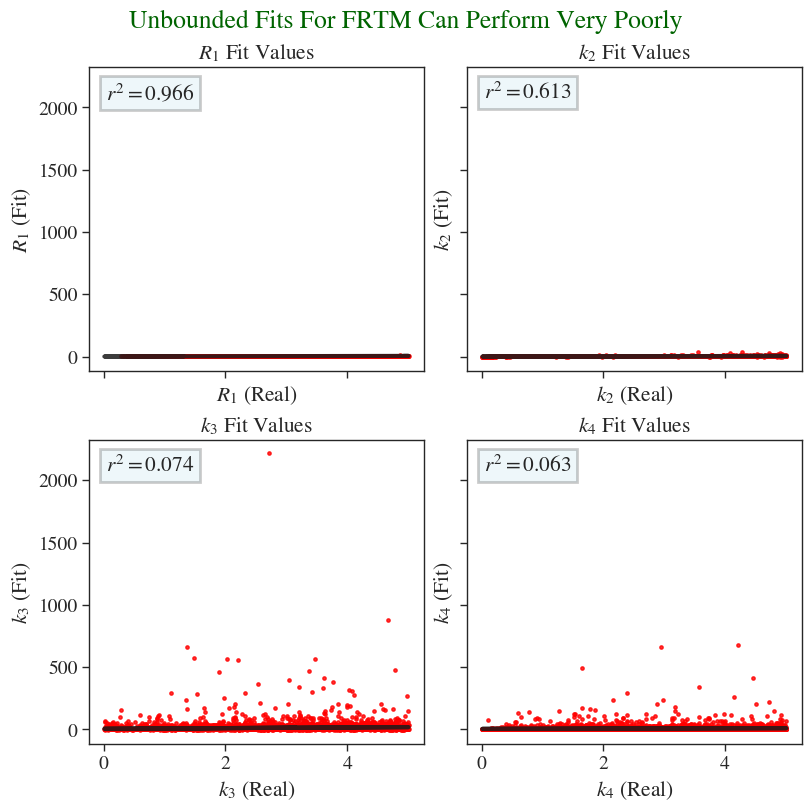

In [62]:
frtm_param_names = [r'$R_1$', r'$k_2$', r'$k_3$', r'$k_4$']
myFig, myAx = plt.subplots(2,2, figsize=[8,8], constrained_layout=True, sharex=True, sharey=True)
fAx = myAx.flatten()
for pID, (xAr, yAr, param) in enumerate(zip(frtm_test_params_large.T, 
                                            frtm_fit_params_unbounded.T,
                                            frtm_param_names)):
    lin_reg = linregress(xAr[~np.isnan(yAr)], yAr[~np.isnan(yAr)])
    fAx[pID].plot(xAr, yAr, '.', alpha=0.8, color='red')
    fAx[pID].plot(xAr, xAr*lin_reg.slope + lin_reg.intercept, lw=3, color='k', alpha=0.85)
    
    fAx[pID].text(0.05, 0.95, fr"$r^2={lin_reg.rvalue:<5.3f}$", 
                  transform=fAx[pID].transAxes, ha='left', va='top', bbox=text_box)
    fAx[pID].set_title(f"{param} Fit Values")
    fAx[pID].set(xlabel=fr'{param} (Real)', ylabel=fr'{param} (Fit)')
myFig.suptitle("Unbounded Fits For FRTM Can Perform Very Poorly", color='darkgreen')
plt.show()

### Bounded Fits

#### Generating Random Samples

In [63]:
num_samples = 5000
r1_params = np.random.random(num_samples)*5.0 + 0.01
k2_params = np.random.random(num_samples)*5.0 + 0.01
k3_params = np.random.random(num_samples)*5.0 + 0.01
k4_params = np.random.random(num_samples)*5.0 + 0.01

frtm_test_params_large = np.vstack([r1_params, k2_params, k3_params, k4_params]).T

model_func = pet_rtms.calc_frtm_tac
frtm_fit_params_bounded = np.zeros_like(frtm_test_params_large)

for tID, t_params in enumerate(frtm_test_params_large[:]):
    rtm_tac_vals = model_func(ref_tac_times, *t_params, ref_tac_vals)
    noisy_tgt_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals, scale=0.01)
    if np.min(rtm_tac_vals) < 0:
        frtm_fit_params_bounded[tID] = np.nan * np.ones(len(t_params), float)
        continue
    try:
        pOpt, pCor = pet_rtms.fit_frtm_to_tac_with_bounds(tgt_tac_vals=noisy_tgt_vals, 
                                                          ref_tac_times=ref_tac_times,
                                                          ref_tac_vals=ref_tac_vals,
                                                          r1_bounds=(0.5, 0.01, 3.0),
                                                          k2_bounds=(0.5, 0.01, 3.0), 
                                                          k3_bounds=(0.5, 0.01, 3.0),
                                                          k4_bounds=(0.5, 0.01, 3.0))
    except RuntimeError:
        pOpt = np.nan * np.ones(len(t_params), float)
        pCor = np.nan * np.ones((len(t_params), len(t_params)), float)
        
    frtm_fit_params_bounded[tID] = pOpt[:]


### Scatter Plot

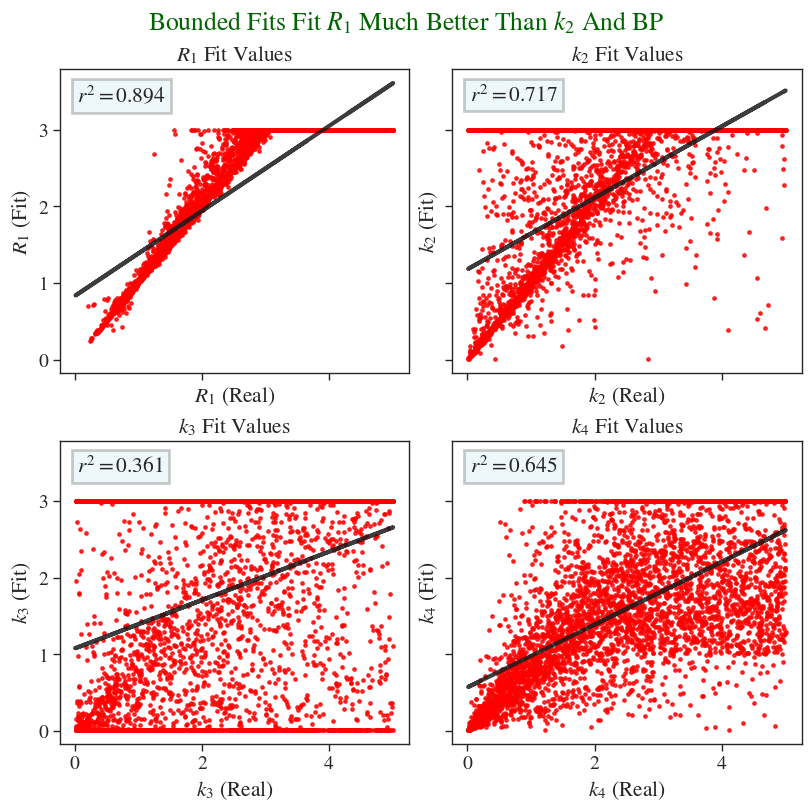

In [64]:
frtm_param_names = [r'$R_1$', r'$k_2$', r'$k_3$', r'$k_4$']
myFig, myAx = plt.subplots(2,2, figsize=[8,8], constrained_layout=True, sharex=True, sharey=True)
fAx = myAx.flatten()
for pID, (xAr, yAr, param) in enumerate(zip(frtm_test_params_large.T, 
                                            frtm_fit_params_bounded.T,
                                            frtm_param_names)):
    lin_reg = linregress(xAr[~np.isnan(yAr)], yAr[~np.isnan(yAr)])
    fAx[pID].plot(xAr, yAr, '.', alpha=0.8, color='red')
    fAx[pID].plot(xAr, xAr*lin_reg.slope + lin_reg.intercept, lw=3, color='k', alpha=0.85)
    
    fAx[pID].text(0.05, 0.95, fr"$r^2={lin_reg.rvalue:<5.3f}$", 
                  transform=fAx[pID].transAxes, ha='left', va='top', bbox=text_box)
    fAx[pID].set_title(f"{param} Fit Values")
    fAx[pID].set(xlabel=fr'{param} (Real)', ylabel=fr'{param} (Fit)')
myFig.suptitle("Bounded Fits Fit $R_1$ Much Better Than $k_2$ And $\mathrm{BP}$", color='darkgreen')
plt.show()